In [1]:
%pip install catboost mne colorlog

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 84.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 105.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Functional preperation


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import utils
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

logger = utils.get_logger()

In [3]:
# test catboost
dataset = np.array([[1,4,5,6],[4,5,6,7],[30,40,50,60],[20,15,85,60]])
train_labels = [1.2,3.4,9.5,24.5]
model = CatBoostRegressor(learning_rate=1, depth=6, loss_function='RMSE')
fit_model = model.fit(dataset, train_labels)

print(fit_model.get_params())

0:	learn: 6.8953900	total: 46.3ms	remaining: 46.2s
1:	learn: 4.8590818	total: 46.4ms	remaining: 23.2s
2:	learn: 3.6271477	total: 46.5ms	remaining: 15.4s
3:	learn: 2.7203608	total: 46.6ms	remaining: 11.6s
4:	learn: 2.0402706	total: 46.6ms	remaining: 9.28s
5:	learn: 1.5302029	total: 46.7ms	remaining: 7.74s
6:	learn: 1.1476522	total: 46.8ms	remaining: 6.64s
7:	learn: 0.8607391	total: 46.9ms	remaining: 5.81s
8:	learn: 0.6455544	total: 47ms	remaining: 5.17s
9:	learn: 0.4841658	total: 47.1ms	remaining: 4.66s
10:	learn: 0.3631243	total: 47.2ms	remaining: 4.24s
11:	learn: 0.2723432	total: 47.2ms	remaining: 3.89s
12:	learn: 0.2042574	total: 47.3ms	remaining: 3.59s
13:	learn: 0.1531931	total: 47.4ms	remaining: 3.34s
14:	learn: 0.1148948	total: 47.5ms	remaining: 3.12s
15:	learn: 0.0861711	total: 47.6ms	remaining: 2.93s
16:	learn: 0.0646283	total: 47.7ms	remaining: 2.75s
17:	learn: 0.0484712	total: 47.7ms	remaining: 2.6s
18:	learn: 0.0363534	total: 47.8ms	remaining: 2.47s
19:	learn: 0.0272651	tota

TBB Warning: The number of workers is currently limited to 3. The request for 95 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



In [3]:
labels_df = utils.get_metadata_df("features-4", "Randomisatielijst.csv")
labels_df

,filename,procedure,patient_id,eeg_type,pre_post
0,TMS-EEG-H_07_S3_rsEEG_pre-epo.csv,itbs,07,rsEEG,pre
1,TMS-EEG-H_06_S2_rsEEG_pre-epo.csv,itbs,06,rsEEG,pre
2,TMS-EEG-H_14_S1_rsEEG_pre-epo.csv,ctbs,14,rsEEG,pre
3,TMS-EEG-H_17_S2_rsEEG_pre-epo.csv,sham,17,rsEEG,pre
4,TMS-EEG-H_16_S3_rsEEG_pre-epo.csv,itbs,16,rsEEG,pre
...,...,...,...,...,...
83,TMS-EEG-H_02_S3_rsEEG_pre-epo.csv,ctbs,02,rsEEG,pre
84,TMS-EEG-H_09_S3_rsEEG_post-epo.csv,sham,09,rsEEG,post
85,TMS-EEG-H_08_s1_rsEEG_pre-epo.csv,sham,08,rsEEG,pre
86,TMS-EEG-H_16_S2_rsEEG_post-epo.csv,sham,16,rsEEG,post


In [4]:
# Create train-test split using feature files
train_filenames, test_filenames = utils.get_train_test_split("features-4", random_state=0)
print(f"Train files: {len(train_filenames)}; Test files: {len(test_filenames)}")

Train files: 71; Test files: 17


In [5]:
def get_data(directory, filenames):
    """Returns a df containing all rows from the given feature files."""
    data = []
    for filename in filenames:
        df = pd.read_csv(os.path.join(directory, filename), header=[0,1])
        data.append(df)
    df = pd.concat(data)
    return df

def get_labels(label_name, label_df, filenames):
    """Returns a df column containg the labels for the given filenames. This is achieved by repeating the respective label for each row in the feature file."""
    labels = []
    for filename in filenames:
        df = pd.read_csv(os.path.join("features-4", filename), header=[0,1])
        rows = df.shape[0]
        label = label_df[label_df['filename'] == filename][label_name].values[0]
        # add label * rows times
        labels.extend([label] * rows)
    df = pd.DataFrame(labels, columns=[label_name])
    return df

In [6]:
def data_prep(train_data_df, train_labels_df, test_data_df, outlier_threshold = 0.05):
    """Standardizes and removes outliers in data."""
    def remove_outliers_zscore(df, threshold=3):
        z_scores = np.abs(zscore(df))
        return df[(z_scores < threshold).all(axis=1)]
    
    # Standardization
    scaler = StandardScaler()
    train_data_df = pd.DataFrame(scaler.fit_transform(train_data_df), columns=train_data_df.columns)
    test_data_df = pd.DataFrame(scaler.fit_transform(test_data_df), columns=test_data_df.columns)
    
    # Outlier removal
    Q1 = train_data_df.quantile(0.10)
    Q3 = train_data_df.quantile(0.90)
    IQR = Q3 - Q1

    def is_outlier(row):
        return ((row < (Q1 - 1.5 * IQR)) | (row > (Q3 + 1.5 * IQR))).sum()

    outlier_counts = train_data_df.apply(is_outlier, axis=1)
    threshold = len(train_data_df.columns) * outlier_threshold
    rows_to_drop = outlier_counts[outlier_counts > threshold].index
    train_data_df_filtered = train_data_df.drop(index=rows_to_drop)
    train_labels_df = train_labels_df.drop(index=rows_to_drop)
    print(f"Original DataFrame shape: {train_data_df.shape}")
    print(f"Filtered DataFrame shape: {train_data_df_filtered.shape}")
    train_data_df = train_data_df_filtered

    return train_data_df, train_labels_df, test_data_df

In [7]:
def train_catboost(train_data, train_labels, test_data, test_labels, loss_function="Logloss"):
    test_data = catboost_pool = Pool(test_data,
                                     test_labels)
    
    model = CatBoostClassifier(iterations=100,
                               depth=5,
                               learning_rate=0.1,
                               loss_function=loss_function,
                               verbose=False)
    # train the model
    model.fit(train_data, train_labels)

    # make test predictions using the resulting model
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    
    accuracy = accuracy_score(test_labels_df, preds_class)
    print("Accuracy on test set: ", accuracy)
    
    return model, accuracy

## Individual model training

Train one model for two paradigms:

1. **pre/post classification**: for a given procedure of a given patient, classify into pre or post procedure
2. **procedure classification**: for a given procedure, classifiy which procedure it was

Train test split is solely from within the patient.

In [8]:
patient_ids = labels_df["patient_id"].unique()

In [20]:
# first paradigm
for patient_id in patient_ids:
    for procedure in ["sham", "itbs", "ctbs"]:
        # make dataframe of all files for this patient and procedure
        files = labels_df[(labels_df["patient_id"] == patient_id) & (labels_df["procedure"] == procedure)]["filename"]
        # get data and labels
        data = get_data("features-4", files)
        labels = get_labels("pre_post", labels_df, files)
        
        train_data_df, test_data_df, train_labels_df, test_labels_df = train_test_split(data, labels, test_size=0.2, random_state=0)
        
        # data prep
        train_data_df_clean, train_labels_df_clean, test_data_df_clean = data_prep(train_data_df, train_labels_df, test_data_df)
        
        # training
        logger.info(f"Training model for patient {patient_id} and procedure {procedure}")
        model, _ = train_catboost(train_data_df_clean, train_labels_df_clean, test_data_df_clean, test_labels_df)

        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)[-5:]
        fig = plt.figure(figsize=(12, 6))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(test_data_df.columns)[sorted_idx])
        plt.title(f'Feature Importance (procedure {procedure})')
        plt.show()

# second paradigm
for patient_id in ["06", "07", "08", "09", "10"]:
    # make dataframe of all files for this patient
    files = labels_df[(labels_df["patient_id"] == patient_id) & (labels_df["pre_post"] == "post")]["filename"]
    
    data = get_data("features-4", files)
    labels = get_labels("procedure", labels_df, files)
        
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
        
    train_data_df = X_train
    train_labels_df = y_train
    test_data_df = X_test
    test_labels_df = y_test
        
    # data prep
    train_data_df_clean, train_labels_df_clean, test_data_df_clean = data_prep(train_data_df, train_labels_df, test_data_df)
        
    # training
    logger.info(f"Training post procedure model for patient {patient_id}")
    model, _ = train_catboost(train_data_df_clean, train_labels_df_clean, test_data_df_clean, test_labels_df, loss_function="MultiClass")

    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[-5:]
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title(f'Feature Importance (patient {patient_id})')
    plt.show()

[2024-08-19 21:37:55,482] - INFO - Training model for patient 07 and procedure sham


Original DataFrame shape: (337, 6913)
Filtered DataFrame shape: (337, 6913)
Accuracy on test set:  0.9882352941176471


TypeError: cannot unpack non-iterable CatBoostClassifier object

## First paradigm using all patients

[2024-08-19 21:39:26,966] - INFO - Procedure: sham
[2024-08-19 21:39:26,969] - INFO - Fold 1
[2024-08-19 21:39:26,970] - INFO - Preparing training data
[2024-08-19 21:40:13,401] - INFO - Preparing testing data
[2024-08-19 21:40:26,769] - INFO - Cleaning data
[2024-08-19 21:40:35,357] - INFO - Training model sham, Fold 1


Original DataFrame shape: (5978, 6913)
Filtered DataFrame shape: (5978, 6913)
Accuracy on test set:  0.5370886781929727


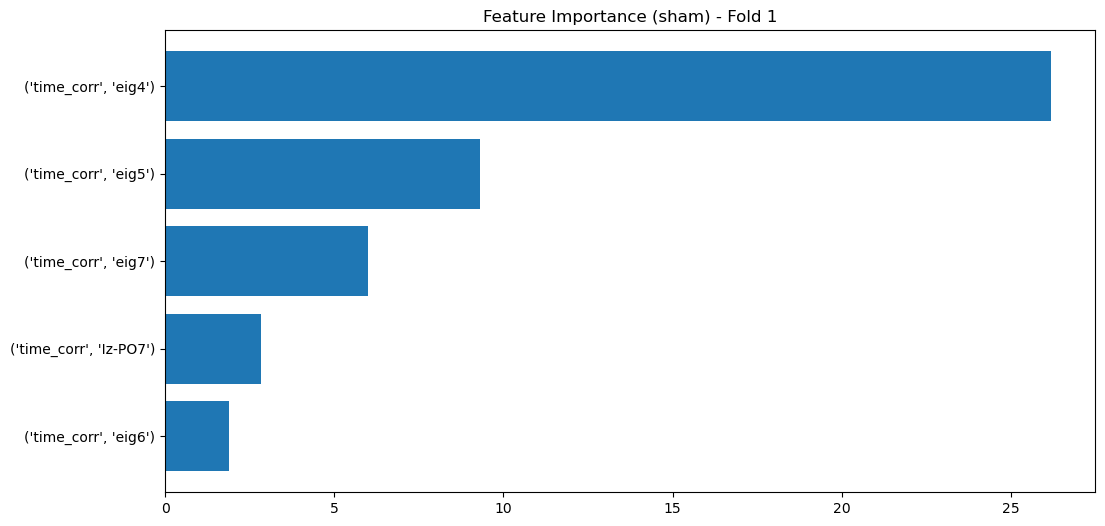

[2024-08-19 21:41:55,407] - INFO - Fold 2
[2024-08-19 21:41:55,408] - INFO - Preparing training data
[2024-08-19 21:42:45,732] - INFO - Preparing testing data
[2024-08-19 21:42:55,179] - INFO - Cleaning data
[2024-08-19 21:43:04,994] - INFO - Training model sham, Fold 2


Original DataFrame shape: (6531, 6913)
Filtered DataFrame shape: (6531, 6913)
Accuracy on test set:  0.5564516129032258


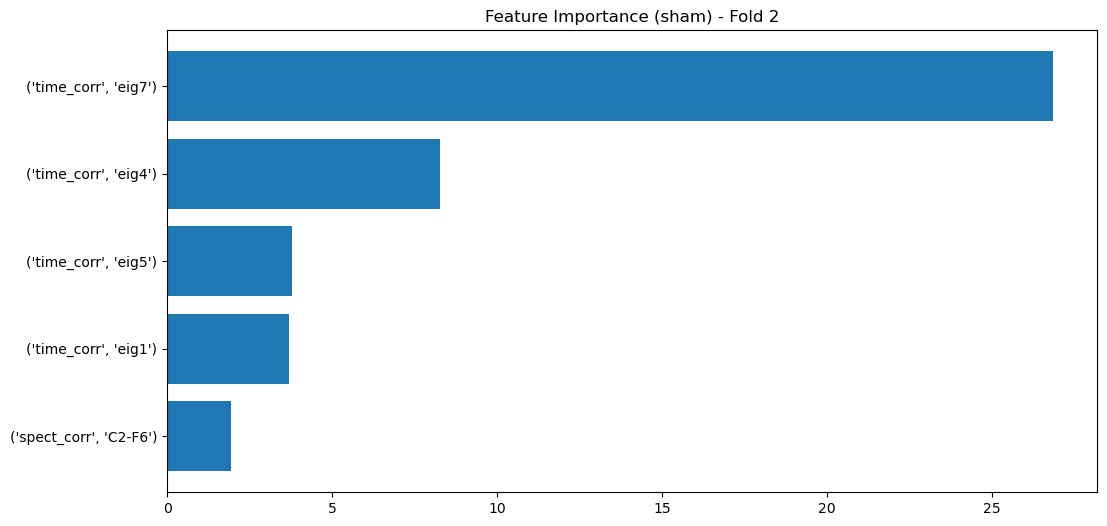

[2024-08-19 21:44:26,301] - INFO - Fold 3
[2024-08-19 21:44:26,302] - INFO - Preparing training data
[2024-08-19 21:45:14,199] - INFO - Preparing testing data
[2024-08-19 21:45:26,441] - INFO - Cleaning data
[2024-08-19 21:45:35,372] - INFO - Training model sham, Fold 3


Original DataFrame shape: (6158, 6913)
Filtered DataFrame shape: (6158, 6913)
Accuracy on test set:  0.5654060756354619


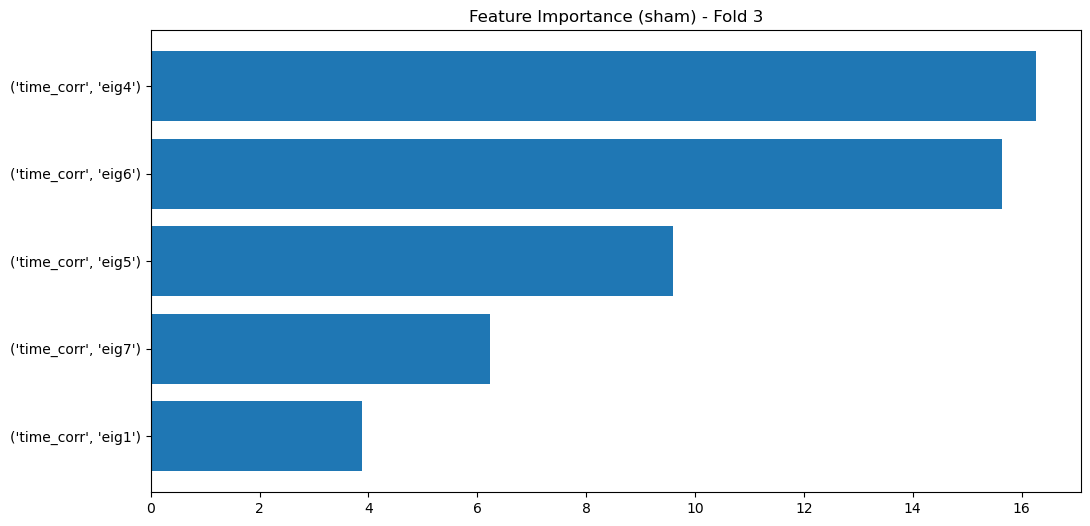

[2024-08-19 21:46:56,186] - INFO - Fold 4
[2024-08-19 21:46:56,187] - INFO - Preparing training data
[2024-08-19 21:47:44,268] - INFO - Preparing testing data
[2024-08-19 21:47:57,048] - INFO - Cleaning data
[2024-08-19 21:48:06,063] - INFO - Training model sham, Fold 4


Original DataFrame shape: (6129, 6913)
Filtered DataFrame shape: (6128, 6913)
Accuracy on test set:  0.48477466504263095


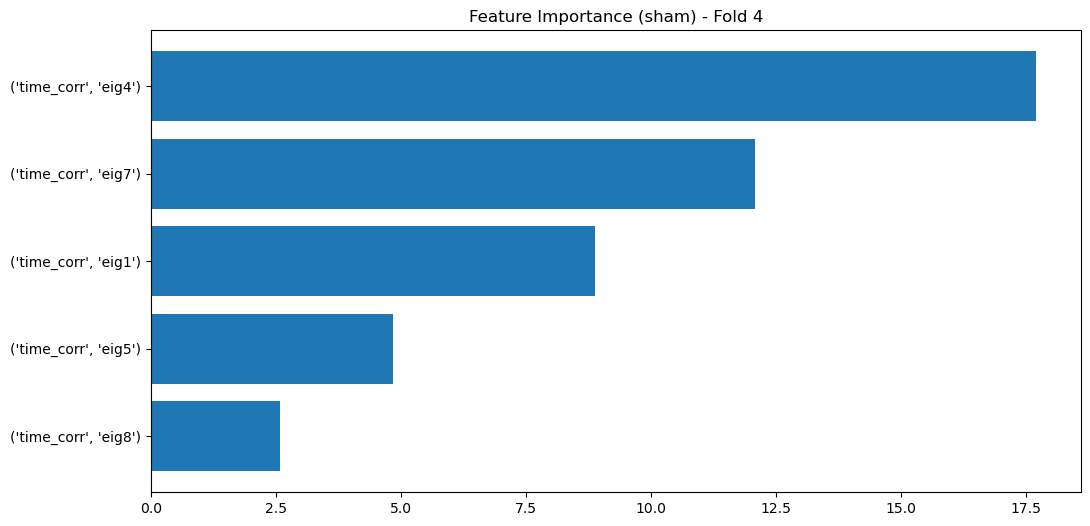

[2024-08-19 21:49:26,469] - INFO - Fold 5
[2024-08-19 21:49:26,470] - INFO - Preparing training data
[2024-08-19 21:50:14,549] - INFO - Preparing testing data
[2024-08-19 21:50:26,477] - INFO - Cleaning data
[2024-08-19 21:50:35,360] - INFO - Training model sham, Fold 5


Original DataFrame shape: (6288, 6913)
Filtered DataFrame shape: (6288, 6913)
Accuracy on test set:  0.476062036412677


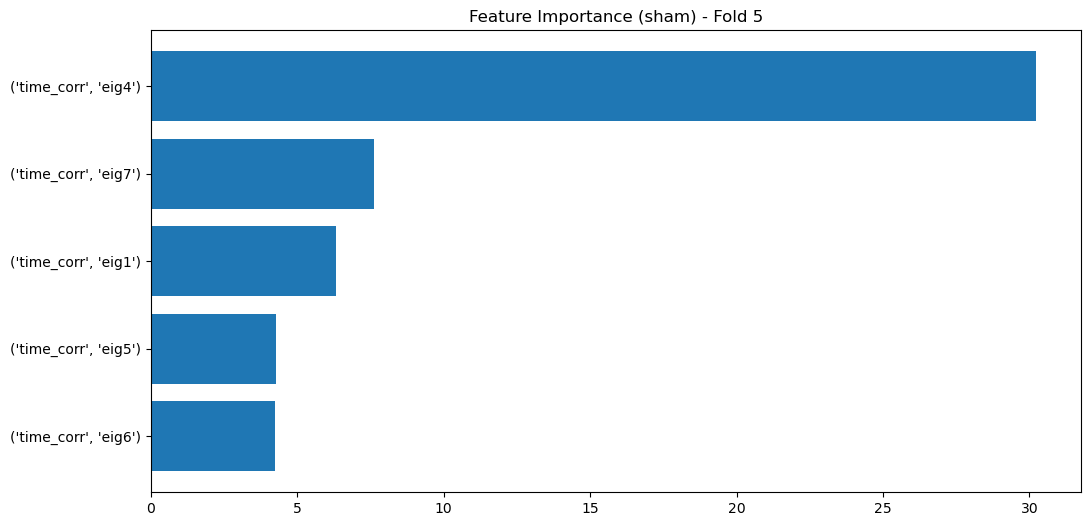

[2024-08-19 21:51:55,802] - INFO - Procedure: itbs
[2024-08-19 21:51:55,806] - INFO - Fold 1
[2024-08-19 21:51:55,807] - INFO - Preparing training data
[2024-08-19 21:52:43,431] - INFO - Preparing testing data
[2024-08-19 21:52:57,569] - INFO - Cleaning data
[2024-08-19 21:53:06,109] - INFO - Training model itbs, Fold 1


Original DataFrame shape: (5946, 6913)
Filtered DataFrame shape: (5946, 6913)
Accuracy on test set:  0.5467625899280576


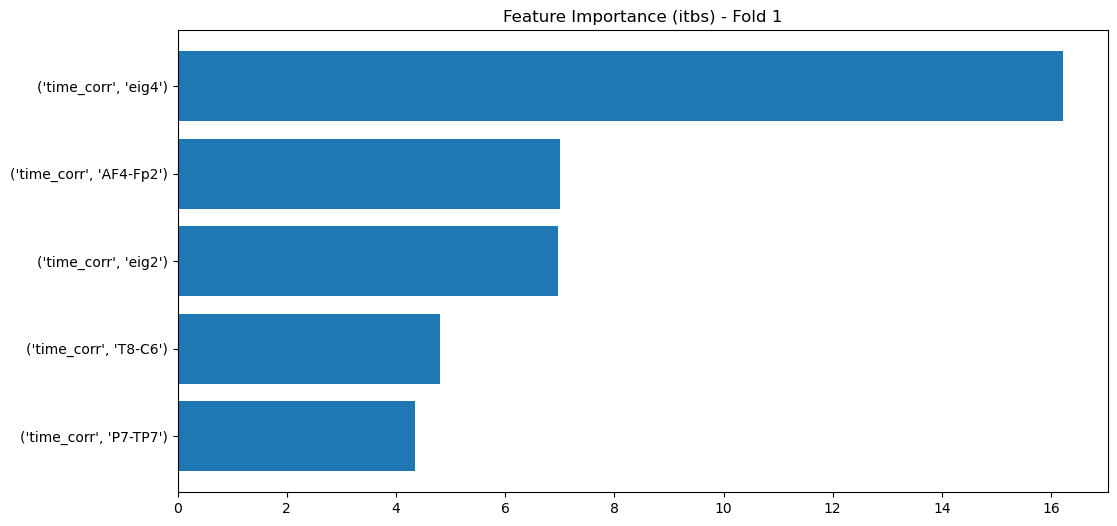

[2024-08-19 21:54:25,795] - INFO - Fold 2
[2024-08-19 21:54:25,796] - INFO - Preparing training data
[2024-08-19 21:55:15,879] - INFO - Preparing testing data
[2024-08-19 21:55:27,388] - INFO - Cleaning data
[2024-08-19 21:55:36,612] - INFO - Training model itbs, Fold 2


Original DataFrame shape: (6433, 6913)
Filtered DataFrame shape: (6433, 6913)
Accuracy on test set:  0.5298149417409185


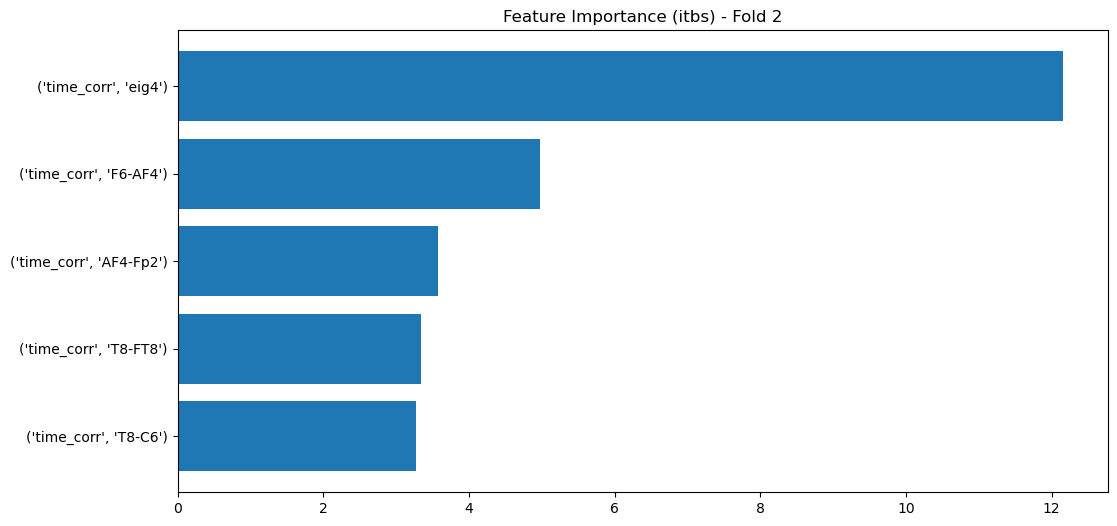

[2024-08-19 21:56:57,803] - INFO - Fold 3
[2024-08-19 21:56:57,804] - INFO - Preparing training data
[2024-08-19 21:57:46,807] - INFO - Preparing testing data
[2024-08-19 21:57:59,846] - INFO - Cleaning data
[2024-08-19 21:58:08,815] - INFO - Training model itbs, Fold 3


Original DataFrame shape: (6251, 6913)
Filtered DataFrame shape: (6251, 6913)
Accuracy on test set:  0.6691042047531993


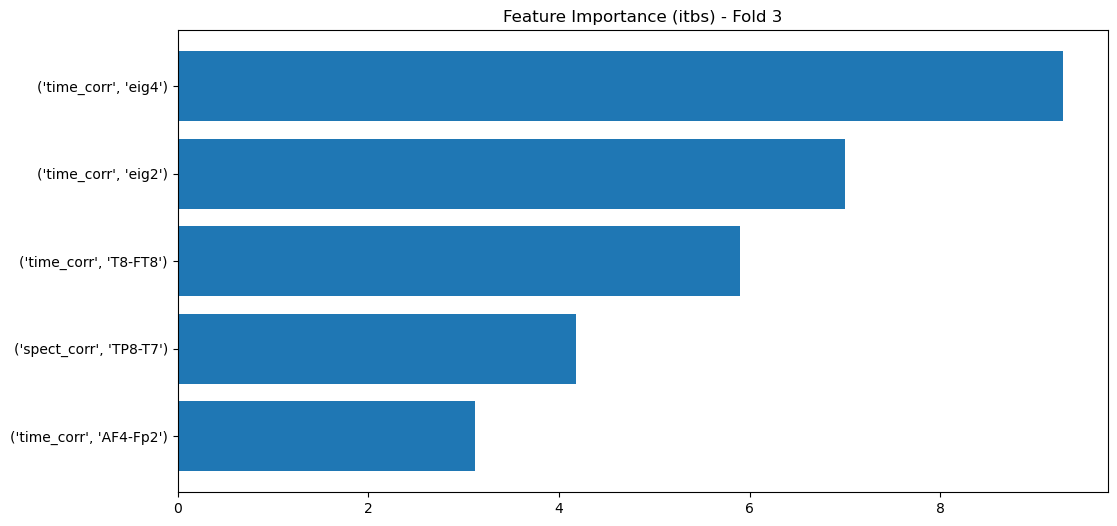

[2024-08-19 21:59:29,312] - INFO - Fold 4
[2024-08-19 21:59:29,313] - INFO - Preparing training data
[2024-08-19 22:00:19,817] - INFO - Preparing testing data
[2024-08-19 22:00:31,255] - INFO - Cleaning data
[2024-08-19 22:00:40,466] - INFO - Training model itbs, Fold 4


Original DataFrame shape: (6487, 6913)
Filtered DataFrame shape: (6487, 6913)
Accuracy on test set:  0.4797153024911032


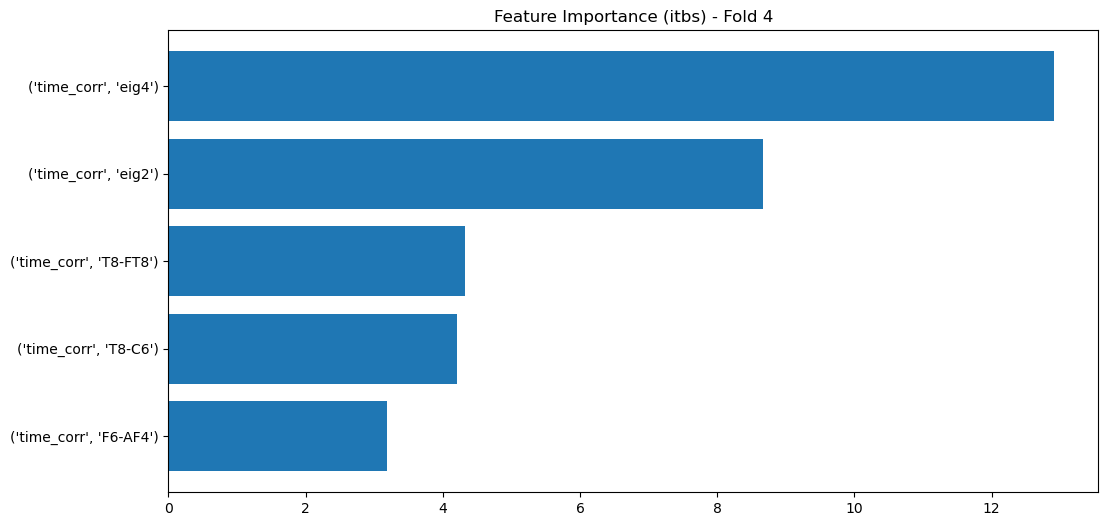

[2024-08-19 22:02:01,025] - INFO - Fold 5
[2024-08-19 22:02:01,027] - INFO - Preparing training data
[2024-08-19 22:02:50,821] - INFO - Preparing testing data
[2024-08-19 22:03:02,071] - INFO - Cleaning data
[2024-08-19 22:03:11,303] - INFO - Training model itbs, Fold 5


Original DataFrame shape: (6451, 6913)
Filtered DataFrame shape: (6451, 6913)
Accuracy on test set:  0.4996530187369882


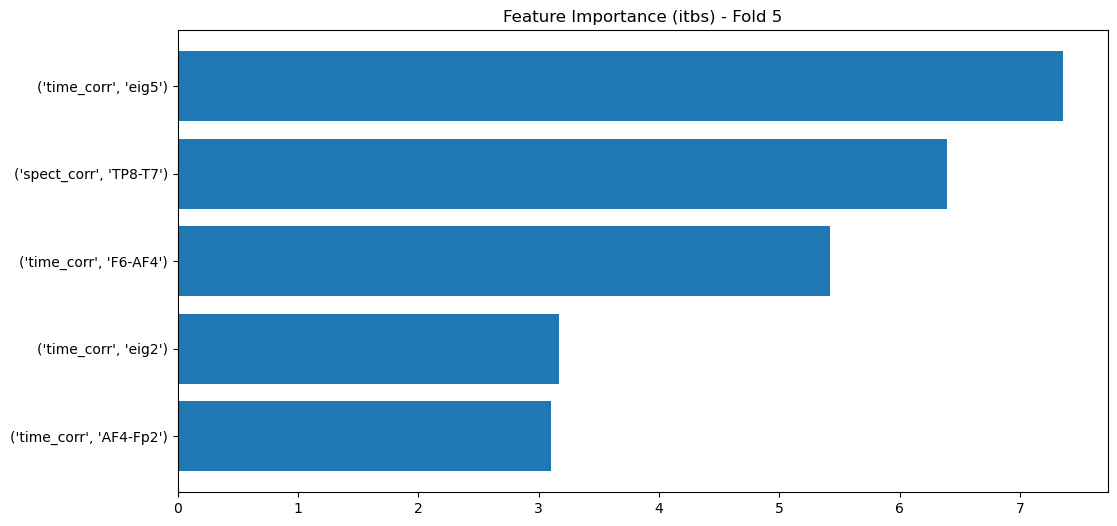

[2024-08-19 22:04:32,909] - INFO - Procedure: ctbs
[2024-08-19 22:04:32,913] - INFO - Fold 1
[2024-08-19 22:04:32,914] - INFO - Preparing training data
[2024-08-19 22:05:18,364] - INFO - Preparing testing data
[2024-08-19 22:05:28,033] - INFO - Cleaning data
[2024-08-19 22:05:36,147] - INFO - Training model ctbs, Fold 1


Original DataFrame shape: (5746, 6913)
Filtered DataFrame shape: (5746, 6913)
Accuracy on test set:  0.351981351981352


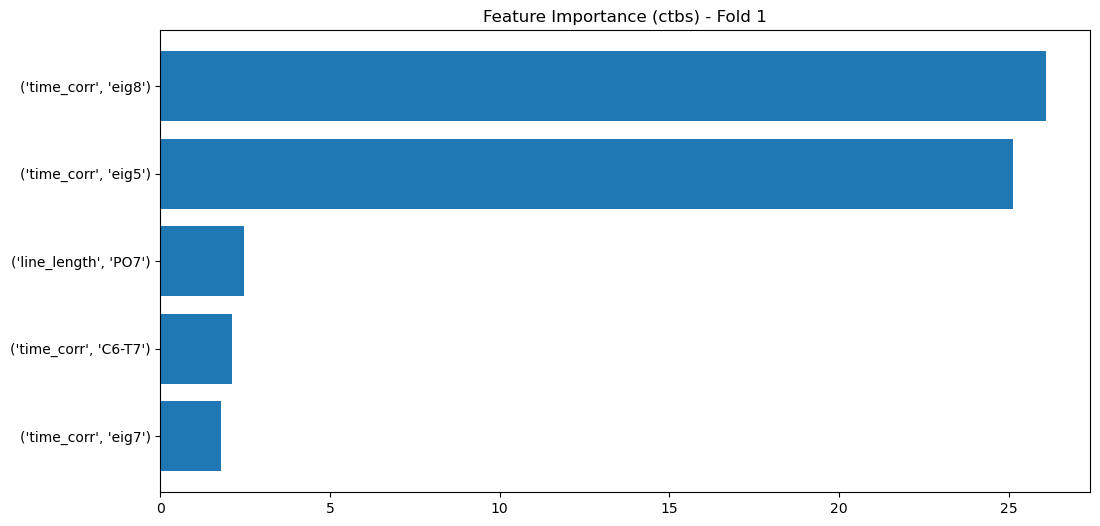

[2024-08-19 22:06:54,092] - INFO - Fold 2
[2024-08-19 22:06:54,094] - INFO - Preparing training data
[2024-08-19 22:07:38,043] - INFO - Preparing testing data
[2024-08-19 22:07:49,578] - INFO - Cleaning data
[2024-08-19 22:07:57,536] - INFO - Training model ctbs, Fold 2


Original DataFrame shape: (5554, 6913)
Filtered DataFrame shape: (5554, 6913)
Accuracy on test set:  0.6369168356997972


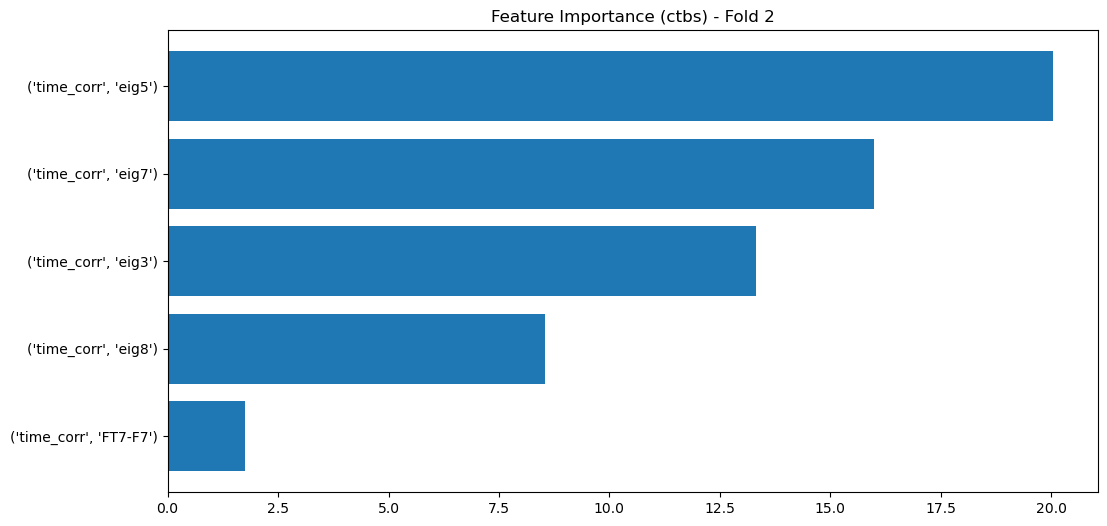

[2024-08-19 22:09:15,087] - INFO - Fold 3
[2024-08-19 22:09:15,088] - INFO - Preparing training data
[2024-08-19 22:09:59,571] - INFO - Preparing testing data
[2024-08-19 22:10:09,990] - INFO - Cleaning data
[2024-08-19 22:10:18,533] - INFO - Training model ctbs, Fold 3


Original DataFrame shape: (5717, 6913)
Filtered DataFrame shape: (5717, 6913)
Accuracy on test set:  0.7393617021276596


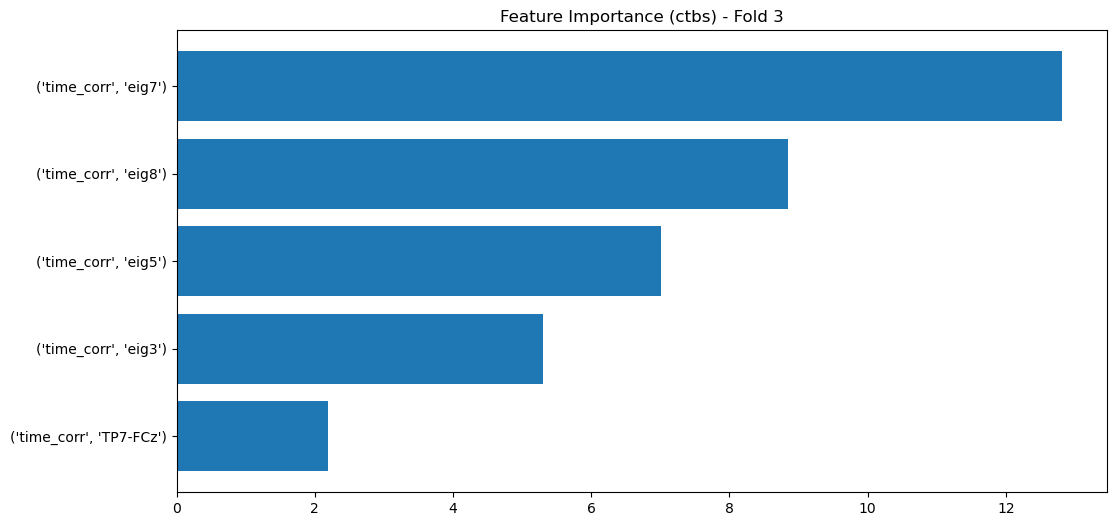

[2024-08-19 22:11:37,934] - INFO - Fold 4
[2024-08-19 22:11:37,936] - INFO - Preparing training data
[2024-08-19 22:12:21,827] - INFO - Preparing testing data
[2024-08-19 22:12:33,063] - INFO - Cleaning data
[2024-08-19 22:12:41,065] - INFO - Training model ctbs, Fold 4


Original DataFrame shape: (5599, 6913)
Filtered DataFrame shape: (5599, 6913)
Accuracy on test set:  0.603905160390516


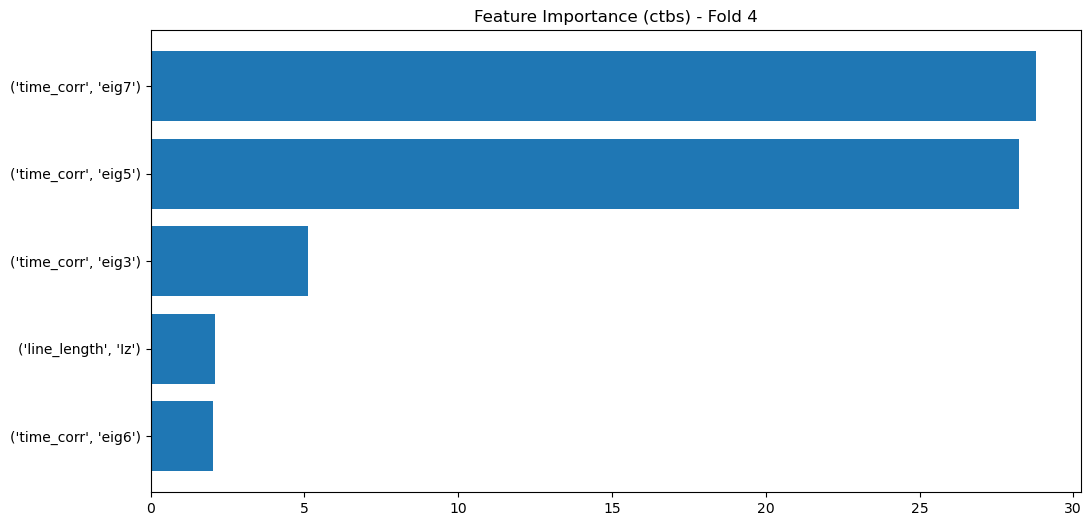

[2024-08-19 22:13:59,217] - INFO - Fold 5
[2024-08-19 22:13:59,218] - INFO - Preparing training data
[2024-08-19 22:14:42,779] - INFO - Preparing testing data
[2024-08-19 22:14:54,651] - INFO - Cleaning data
[2024-08-19 22:15:02,689] - INFO - Training model ctbs, Fold 5


Original DataFrame shape: (5516, 6913)
Filtered DataFrame shape: (5516, 6913)
Accuracy on test set:  0.6348055372445617


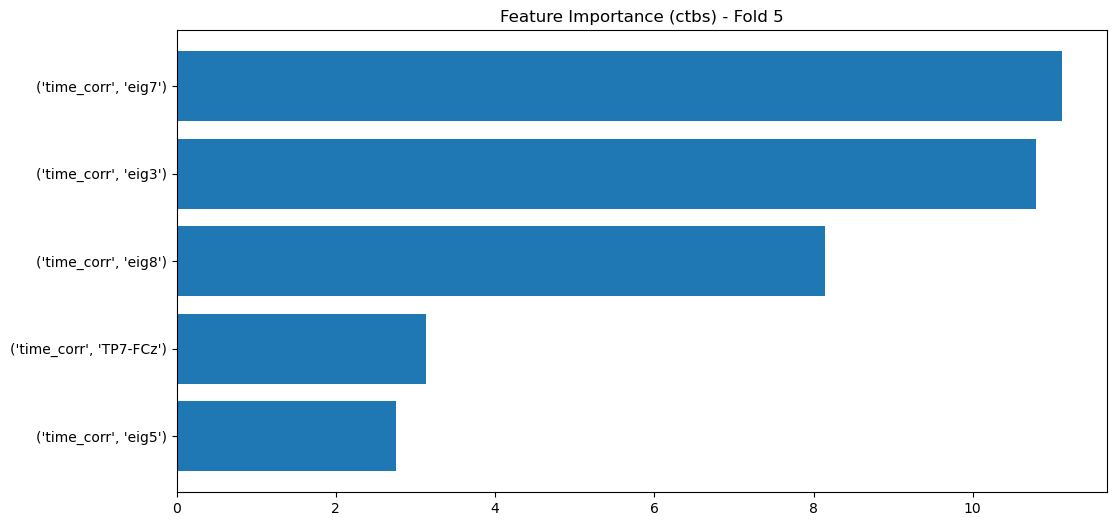

In [22]:
from sklearn.model_selection import KFold
import numpy as np

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

accuracies = {
    "sham": [],
    "itbs": [],
    "ctbs": []
}

# Iterate over procedures
for procedure in ["sham", "itbs", "ctbs"]:
    logger.info(f"Procedure: {procedure}")
    
    # Iterate over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(patient_ids)):
        logger.info(f"Fold {fold+1}")        
        train_patient_ids = np.array(patient_ids)[train_index]
        test_patient_ids = np.array(patient_ids)[test_index]

        logger.info(f"Preparing training data")
        train_files = labels_df[(labels_df["patient_id"].isin(train_patient_ids)) & (labels_df["procedure"] == procedure)]["filename"]
        train_data_df = get_data("features-4", train_files)
        train_labels_df = get_labels("pre_post", labels_df, train_files)

        logger.info(f"Preparing testing data")
        test_files = labels_df[(labels_df["patient_id"].isin(test_patient_ids)) & (labels_df["procedure"] == procedure)]["filename"]
        test_data_df = get_data("features-4", test_files)
        test_labels_df = get_labels("pre_post", labels_df, test_files)

        logger.info(f"Cleaning data")
        train_data_df_clean, train_labels_df_clean, test_data_df_clean = data_prep(train_data_df, train_labels_df, test_data_df)

        logger.info(f"Training model {procedure}, Fold {fold+1}")
        model, accuracy = train_catboost(train_data_df_clean, train_labels_df_clean, test_data_df_clean, test_labels_df)

        accuracies[procedure].append(accuracy)
        
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)[-5:]
        fig = plt.figure(figsize=(12, 6))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(test_data_df.columns)[sorted_idx])
        plt.title(f'Feature Importance ({procedure}) - Fold {fold+1}')
        plt.show()

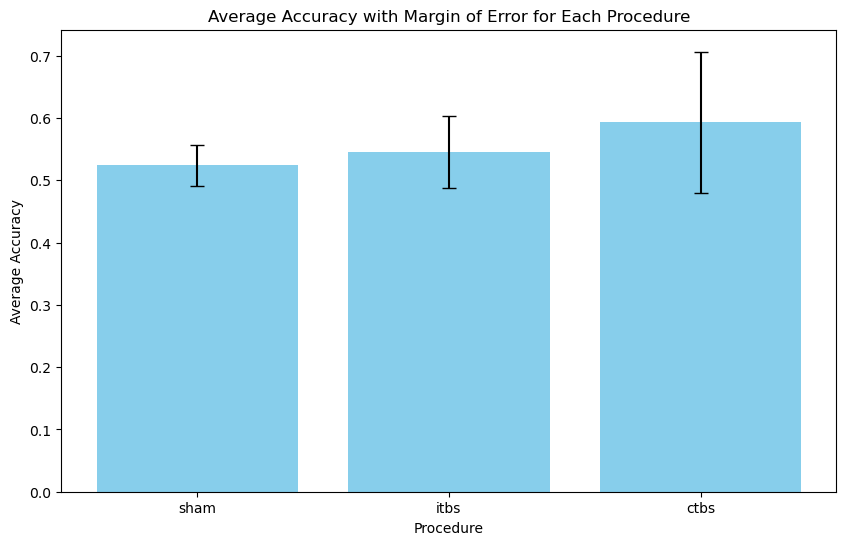

  Procedure  Average Accuracy  Margin of Error
0      sham          0.523957         0.032267
1      itbs          0.545010         0.058082
2      ctbs          0.593394         0.113142


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate average accuracy and margin of error for each procedure
average_accuracies = {}
margin_of_errors = {}
for procedure, acc in accuracies.items():
    avg_acc = np.mean(acc)
    margin_error = np.std(acc) / np.sqrt(len(acc)) * 1.96  # 95% confidence interval
    average_accuracies[procedure] = avg_acc
    margin_of_errors[procedure] = margin_error

# Plotting
procedures = list(average_accuracies.keys())
avg_acc_values = list(average_accuracies.values())
margin_error_values = list(margin_of_errors.values())

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(procedures, avg_acc_values, yerr=margin_error_values, capsize=5, color='skyblue')
ax.set_xlabel('Procedure')
ax.set_ylabel('Average Accuracy')
ax.set_title('Average Accuracy with Margin of Error for Each Procedure')
plt.show()

results_df = pd.DataFrame({
    'Procedure': list(average_accuracies.keys()),
    'Average Accuracy': list(average_accuracies.values()),
    'Margin of Error': list(margin_of_errors.values())
})

# Display the table
print(results_df)

## Second paradigm using all patients

[2024-08-20 08:26:33,064] - INFO - Fold 1
[2024-08-20 08:26:33,066] - INFO - Preparing training data
[2024-08-20 08:27:28,157] - INFO - Preparing testing data
[2024-08-20 08:27:41,937] - INFO - Cleaning data
[2024-08-20 08:28:05,691] - INFO - Training model, Fold 1


Original DataFrame shape: (8914, 6913)
Filtered DataFrame shape: (8911, 6913)
Accuracy on test set:  0.3568596352101507


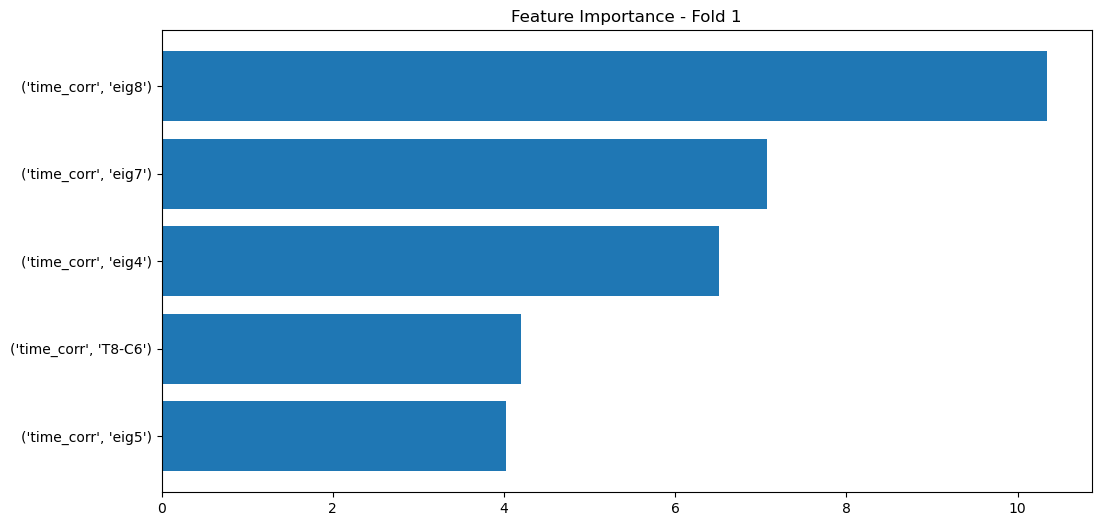

[2024-08-20 08:30:30,169] - INFO - Fold 2
[2024-08-20 08:30:30,170] - INFO - Preparing training data
[2024-08-20 08:31:25,024] - INFO - Preparing testing data
[2024-08-20 08:31:38,110] - INFO - Cleaning data
[2024-08-20 08:32:00,584] - INFO - Training model, Fold 2


Original DataFrame shape: (9176, 6913)
Filtered DataFrame shape: (9176, 6913)
Accuracy on test set:  0.37787610619469025


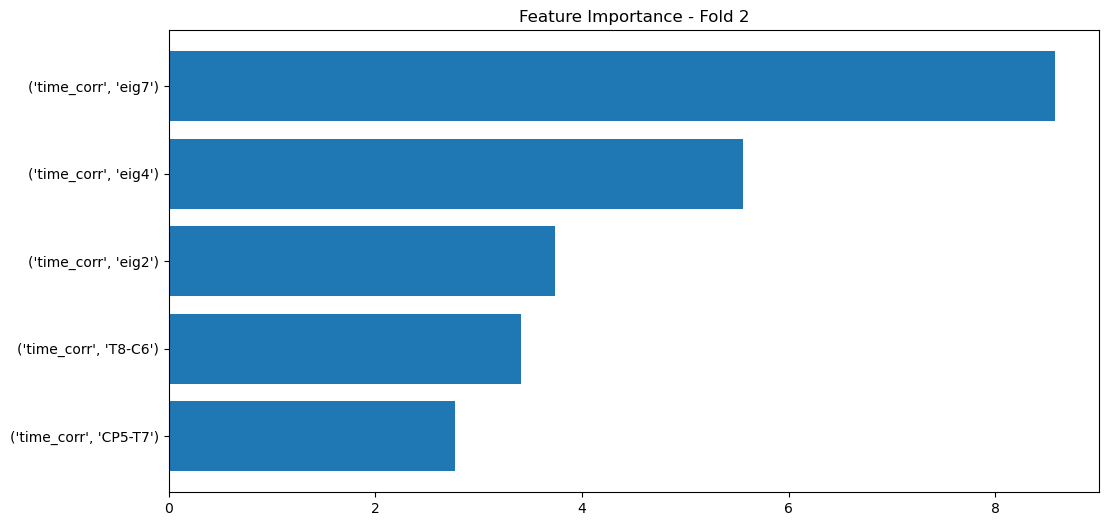

[2024-08-20 08:34:26,410] - INFO - Fold 3
[2024-08-20 08:34:26,412] - INFO - Preparing training data
[2024-08-20 08:35:19,867] - INFO - Preparing testing data
[2024-08-20 08:35:34,352] - INFO - Cleaning data
[2024-08-20 08:35:59,362] - INFO - Training model, Fold 3


Original DataFrame shape: (9070, 6913)
Filtered DataFrame shape: (9066, 6913)
Accuracy on test set:  0.45815722738799664


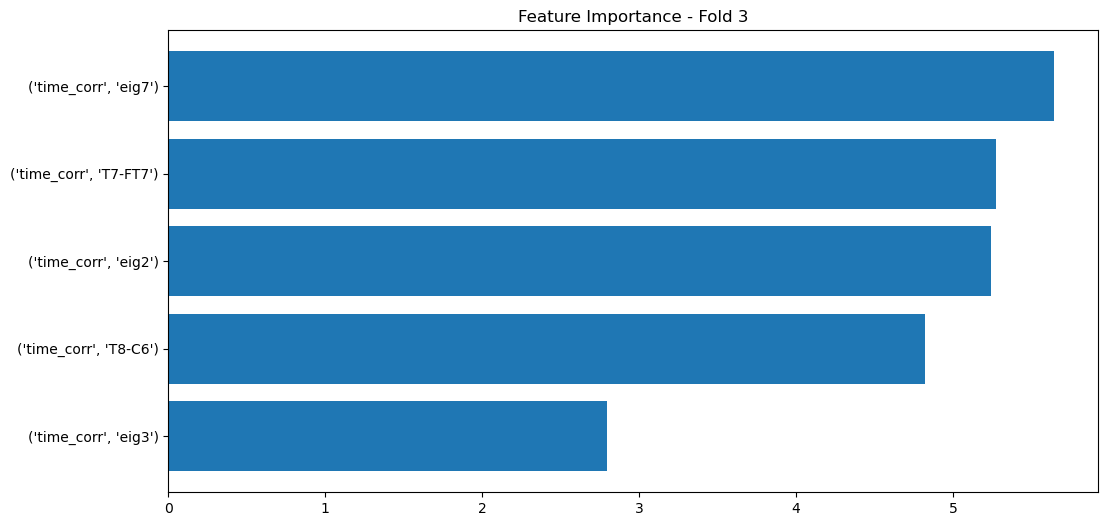

[2024-08-20 08:38:25,996] - INFO - Fold 4
[2024-08-20 08:38:25,998] - INFO - Preparing training data
[2024-08-20 08:39:21,212] - INFO - Preparing testing data
[2024-08-20 08:39:34,906] - INFO - Cleaning data
[2024-08-20 08:39:56,059] - INFO - Training model, Fold 4


Original DataFrame shape: (9298, 6913)
Filtered DataFrame shape: (9293, 6913)
Accuracy on test set:  0.49953227315247895


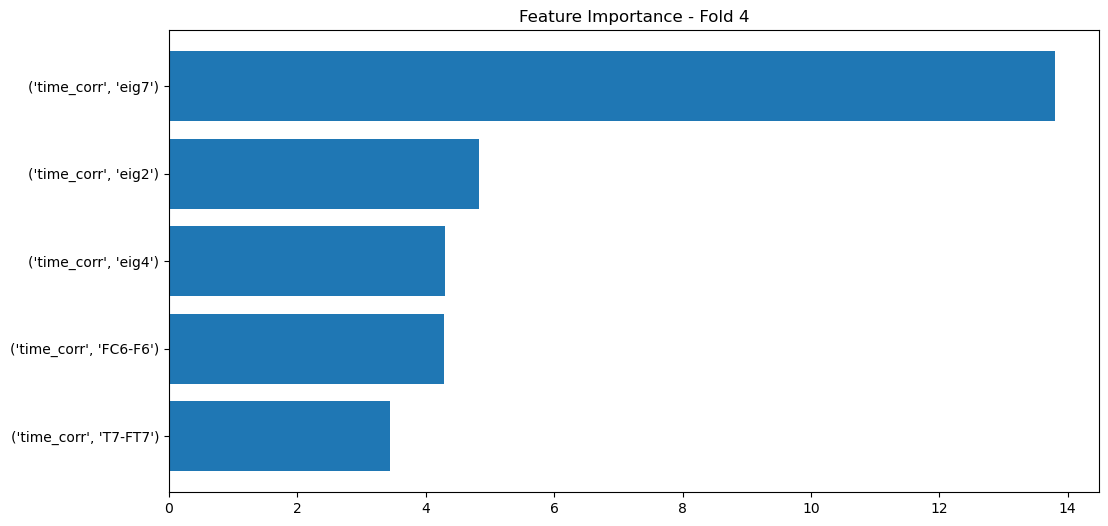

[2024-08-20 08:42:24,163] - INFO - Fold 5
[2024-08-20 08:42:24,164] - INFO - Preparing training data
[2024-08-20 08:43:18,784] - INFO - Preparing testing data
[2024-08-20 08:43:32,375] - INFO - Cleaning data
[2024-08-20 08:43:55,659] - INFO - Training model, Fold 5


Original DataFrame shape: (9286, 6913)
Filtered DataFrame shape: (9283, 6913)
Accuracy on test set:  0.3893023255813953


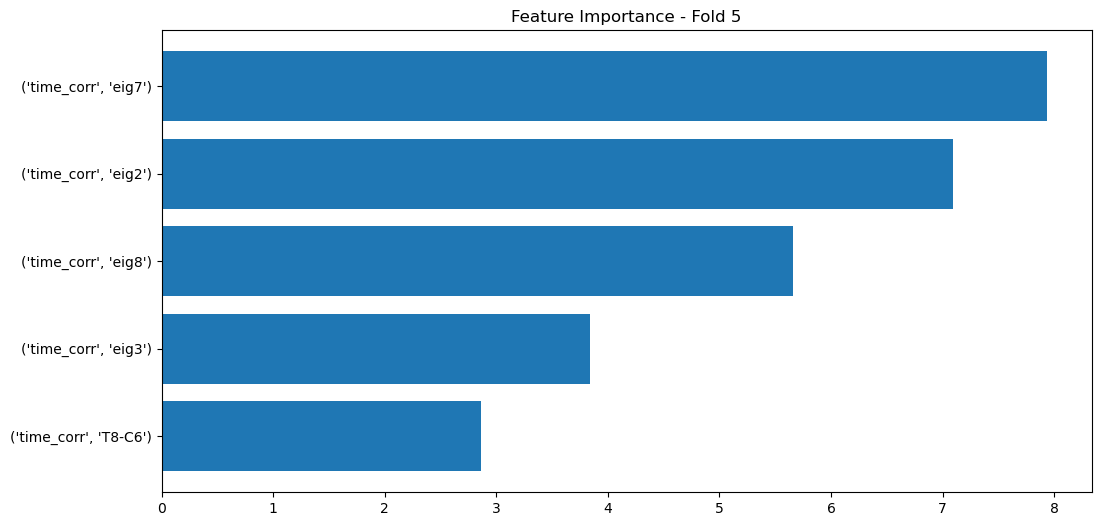

In [10]:
from sklearn.model_selection import KFold
import numpy as np

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

accuracies = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(patient_ids)):
    logger.info(f"Fold {fold+1}")
    train_patient_ids = np.array(patient_ids)[train_index]
    test_patient_ids = np.array(patient_ids)[test_index]

    logger.info(f"Preparing training data")
    train_files = labels_df[(labels_df["patient_id"].isin(train_patient_ids)) & (labels_df["pre_post"] == "post")]["filename"]
    train_data_df = get_data("features-4", train_files)
    train_labels_df = get_labels("procedure", labels_df, train_files)

    logger.info(f"Preparing testing data")
    test_files = labels_df[(labels_df["patient_id"].isin(test_patient_ids)) & (labels_df["pre_post"] == "post")]["filename"]
    test_data_df = get_data("features-4", test_files)
    test_labels_df = get_labels("procedure", labels_df, test_files)

    logger.info(f"Cleaning data")
    train_data_df_clean, train_labels_df_clean, test_data_df_clean = data_prep(train_data_df, train_labels_df, test_data_df)

    logger.info(f"Training model, Fold {fold+1}")
    model, accuracy = train_catboost(train_data_df_clean, train_labels_df_clean, test_data_df_clean, test_labels_df, loss_function="MultiClass")

    accuracies.append(accuracy)
    
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[-5:]
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(test_data_df.columns)[sorted_idx])
    plt.title(f'Feature Importance - Fold {fold+1}')
    plt.show()

In [11]:
average_accuracy = np.mean(accuracies)
margin_of_error = np.std(accuracies) / np.sqrt(len(accuracies)) * 1.96  # 95% confidence interval

results_df = pd.DataFrame({
    'Metric': ['Average Accuracy', 'Margin of Error'],
    'Value': [average_accuracy, margin_of_error]
})

# Display the table
print(results_df)

             Metric     Value
0  Average Accuracy  0.416346
1   Margin of Error  0.047069


As expected based on the clustering, these paradigms are perfectly predictable for the machine learning model. This doesn't extend to other patients however, so it's of little use.